# Machine learning model to read reviews

Question: how can we analyze a large number or reviews with NPL?

Goal: enable companies to quickly extract the key topics covered from the customer feedback without having to read through them one by one

In [1]:
# 1 Import dependencies
from sqlalchemy import create_engine
import pandas as pd
import spacy

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models
%matplotlib inline

# Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist

# Libraries for word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# 2 Postgres username, password, and database name
POSTGRES_ADDRESS = 'mypostgresdb.cwuhtytzosg8.us-east-2.rds.amazonaws.com' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'root' 
POSTGRES_PASSWORD = 'XXXX' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD
POSTGRES_DBNAME = 'my_data_class_db'
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# 3 Load database for sentiment/topic analysis
df = pd.read_sql_query('''SELECT * FROM airmattress_cleaned''', con=cnx)
df.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_headline,review_body
0,51982153,R1DZ76NBD2TX55,5,my wife and i had to pick one of these up over...,my wife and i had to pick one of these up over...
1,44662747,R3G4HN08IK8Q5W,5,this is big and comfortable it inflatesdeflat...,this is big and comfortable it inflatesdeflat...
2,17097525,R1S3TBZK71L487,1,horrible it was so comfortable for the first f...,horrible it was so comfortable for the first f...
3,29924839,R9P8YG335IDYV,5,we bought this so our friends kids would have ...,we bought this so our friends kids would have ...
4,46198682,R5VTP1LCQIATH,4,this bed exceeded my expectations in sturdines...,this bed exceeded my expectations in sturdines...


### Prepare data for ML model

In [4]:
# 4 function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count", color = 'black')
  ax.set(ylabel = 'Count')
  plt.show()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


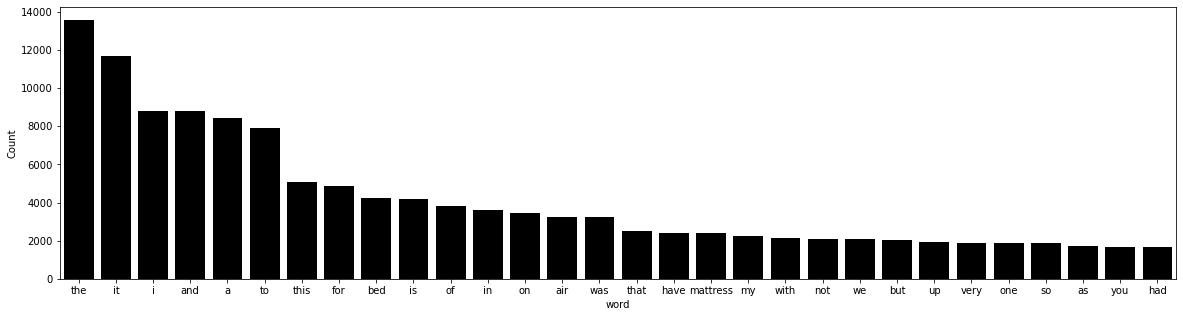

In [5]:
freq_words(df['review_body'])

In [6]:
# 5 Remove unwanted characters, numbers and symbols
df['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")
df

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,customer_id,review_id,star_rating,review_headline,review_body
0,51982153,R1DZ76NBD2TX55,5,my wife and i had to pick one of these up over...,my wife and i had to pick one of these up over...
1,44662747,R3G4HN08IK8Q5W,5,this is big and comfortable it inflatesdeflat...,this is big and comfortable it inflatesdeflat...
2,17097525,R1S3TBZK71L487,1,horrible it was so comfortable for the first f...,horrible it was so comfortable for the first f...
3,29924839,R9P8YG335IDYV,5,we bought this so our friends kids would have ...,we bought this so our friends kids would have ...
4,46198682,R5VTP1LCQIATH,4,this bed exceeded my expectations in sturdines...,this bed exceeded my expectations in sturdines...
...,...,...,...,...,...
4748,10221632,R2K0TL4VNH71AB,5,good buy very little leak the bed itself is ve...,good buy very little leak the bed itself is ve...
4749,52922779,R3FMSB7NVM64SP,5,this is a great thing to have the built in pum...,this is a great thing to have the built in pum...
4750,45643821,R3JPX7JXE4JF61,5,this air mattress is incredible we bought it ...,this air mattress is incredible we bought it ...
4751,14464916,R2XZEVT9OE0BXI,4,i have not had this item for very long and hav...,i have not had this item for very long and hav...


In [7]:
# 6 Remove stop words

stop_words = stopwords.words('english')

# Remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# Remove short words (length < 3)
df['review_body'] = df['review_body'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# Exclude stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['review_body']]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# 7 To remove noise from reviews, use lemmatization from spaCy library
!python -m spacy download en_core_web_sm 

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-05-11 17:54:43.490679: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-05-11 17:54:43.490704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
# 8 Use nlp to remove words that are not aggregating to analysis, using only adjectives
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
def lemmatization(texts, tags=['ADJ']): # filter adjective only
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['big', 'comfortable', 'inflatesdeflates', 'unfoldfold', 'hope', 'lasts', 'long', 'time']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['big', 'comfortable', 'long']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


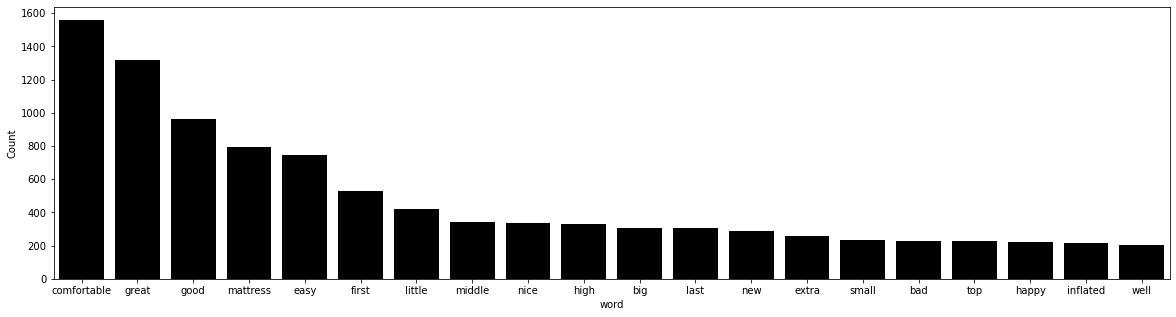

In [12]:
# 9 Show word count after reviews clean up
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 20)

It will be easier to understand good and bad customer feedback if we break the analysis into good reviews and bad reviews

### Develop 2 separate analysis: good reviews from bad reviews

Create 2 dataframes, one with only 1 star reviews and another with 2 star reviews to get a better sense of the good and bad feedback

In [13]:
# 10 Create df for only bad reviews, 1-star
df_1star = df[df['star_rating'] == 1]
df_1star.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_headline,review_body,reviews
2,17097525,R1S3TBZK71L487,1,horrible it was so comfortable for the first f...,horrible was comfortable for the first few day...,horrible comfortable first first bad bad hourl...
5,11489596,R157632LYK6UT6,1,i wish i could return this item i read almost ...,wish could return this item read almost all re...,many negative arrogant prior heavy personbr
6,12256364,R2759URB10Q8RD,1,our bad experience is the same as some others ...,our bad experience the same some others have e...,bad first nice comfortable flat top able small...
12,15328213,R6ISQWC1P9QMC,1,thought this was a great choice and it was unt...,thought this was great choice and was until de...,great third middle visible
29,22202716,R383PLOVTFG353,1,ok i ordered this on november 17th 2013 and i ...,ordered this november and got couple days afte...,big middle


In [14]:
# 11 Create df for only good reviews, 5-stars
df_5stars = df[df['star_rating'] == 5]
df_5stars.head()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,review_id,star_rating,review_headline,review_body,reviews
0,51982153,R1DZ76NBD2TX55,5,my wife and i had to pick one of these up over...,wife and had pick one these over the holiday f...,little concerned blowup first dead tired secon...
1,44662747,R3G4HN08IK8Q5W,5,this is big and comfortable it inflatesdeflat...,this big and comfortable inflatesdeflates itse...,big comfortable long
3,29924839,R9P8YG335IDYV,5,we bought this so our friends kids would have ...,bought this our friends kids would have extra ...,extra twice last great high nice extra great
7,22867429,R238AOC9MSH1XZ,5,grandkids love this so do we it is comfortab...,grandkids love this comfortable and large enou...,comfortable large small great
8,40522779,R3BYPZR2ROSYJ5,5,enough said doesnt deflate yet at least and fe...,enough said doesnt deflate yet least and feels...,least many


In [15]:
# 12 Remove unwanted characters, numbers and symbols
df_1star['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")
df_5stars['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_l

In [16]:
# 13 Remove stopwords
stop_words = stopwords.words('english')

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# Exclude stopwords from the text
reviews_1star = [remove_stopwords(r.split()) for r in df_1star['review_body']]
reviews_5stars = [remove_stopwords(r.split()) for r in df_5stars['review_body']]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# 14 Use nlp to remove words that are not aggregating to analysis, using only adjectives
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
def lemmatization(texts, tags=['ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
tokenized_reviews_1star = pd.Series(reviews_1star).apply(lambda x: x.split())
tokenized_reviews_5stars = pd.Series(reviews_5stars).apply(lambda x: x.split())
print(tokenized_reviews_1star[1])
print(tokenized_reviews_5stars[1])

['wish', 'could', 'return', 'item', 'read', 'almost', 'reviews', 'making', 'purchase', 'could', 'believe', 'item', 'still', 'sold', 'amazon', 'many', 'negative', 'experiences', 'thinking', 'follow', 'instructions', 'work', 'arrogant', 'part', 'would', 'buy', 'againabsolutely', 'leakabsolutely', 'definitely', 'yes', 'could', 'even', 'use', 'one', 'night', 'leaked', 'much', 'followed', 'instructions', 'set', 'prior', 'use', 'instructed', 'point', 'seemed', 'okay', 'leaks', 'weight', 'addedeven', 'lbs', 'weight', 'even', 'take', 'heavy', 'personbr', 'choice', 'whether', 'buy', 'personally', 'would', 'touch', 'product', 'brand', 'ever', 'since', 'trust', 'anymore']
['big', 'comfortable', 'inflatesdeflates', 'unfoldfold', 'hope', 'lasts', 'long', 'time']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
reviews_1star_2 = lemmatization(tokenized_reviews_1star)
reviews_5stars_2 = lemmatization(tokenized_reviews_5stars)

print(reviews_1star_2[1]) 
print(reviews_5stars_2[1]) 

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['many', 'negative', 'arrogant', 'prior', 'heavy', 'personbr']
['big', 'comfortable', 'long']


C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


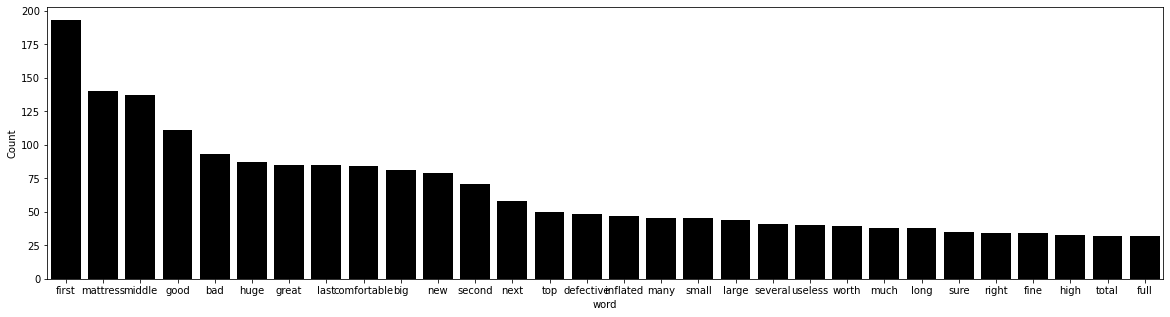

In [20]:
# 15 Create chart frequent words for 1 star reviews
reviews_1star_3 = []
for i in range(len(reviews_1star_2 )):
    reviews_1star_3.append(' '.join(reviews_1star_2[i]))

df_1star['reviews'] = reviews_1star_3

freq_words(df_1star['reviews'], 30)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


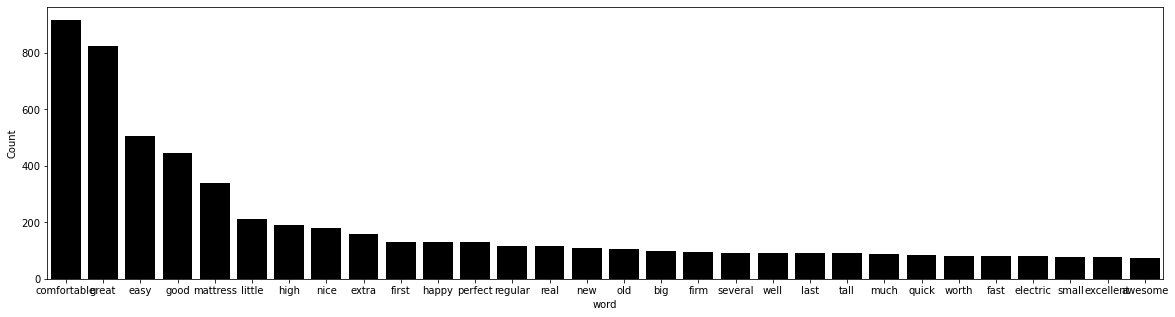

In [21]:
# 16 Create chart frequent words for 5 star reviews
reviews_5stars_3 = []
for i in range(len(reviews_5stars_2 )):
    reviews_5stars_3.append(' '.join(reviews_5stars_2[i]))

df_5stars['reviews'] = reviews_5stars_3

freq_words(df_5stars['reviews'], 30)

### Create Latent Dirichlet Allocation (LDA) model

One application of LDA in machine learning - specifically, topic discovery, a subproblem in natural language processing - is to discover topics in a collection of documents, and then automatically classify any individual document within the collection in terms of how "relevant" it is to each of the discovered topics. A topic is considered to be a set of terms (i.e., individual words or phrases) that, taken together, suggest a shared theme. Souce: Wikipedia

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts. Source: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [22]:
# 17 Import dependencies for LDA model
import gensim
from gensim import corpora

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.wa

In [23]:
# 18 Create the term dictionary of our corpus, unique terms are assigned an index
dictionary_1star = corpora.Dictionary(reviews_1star_2)
dictionary_5stars = corpora.Dictionary(reviews_5stars_2)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# 19 Transform list of reviews into a document term matrix
doc_term_matrix_1star = [dictionary_1star.doc2bow(rev) for rev in reviews_1star_2]
doc_term_matrix_5stars = [dictionary_5stars.doc2bow(rev) for rev in reviews_5stars_2]

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# 20 Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model. In this case we specifified # of topics = 5
lda_model_1star = LDA(corpus=doc_term_matrix_1star, id2word=dictionary_1star, num_topics=5, random_state=100,
                chunksize=1000, passes=50)

lda_model_5stars = LDA(corpus=doc_term_matrix_5stars, id2word=dictionary_5stars, num_topics=5, random_state=100,
                chunksize=1000, passes=50)

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# 21 Print topics 1 star
lda_model_1star.print_topics()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.048*"last" + 0.044*"great" + 0.031*"first" + 0.030*"mattress" + 0.025*"new" + 0.025*"old" + 0.025*"well" + 0.023*"extra" + 0.023*"disappointed" + 0.022*"total"'),
 (1,
  '0.049*"bad" + 0.033*"new" + 0.027*"huge" + 0.026*"mattress" + 0.026*"many" + 0.023*"useless" + 0.020*"big" + 0.019*"negative" + 0.018*"internal" + 0.015*"poor"'),
 (2,
  '0.037*"mattress" + 0.027*"first" + 0.026*"small" + 0.023*"great" + 0.022*"large" + 0.021*"middle" + 0.018*"fine" + 0.018*"less" + 0.017*"terrible" + 0.016*"unusable"'),
 (3,
  '0.057*"good" + 0.048*"middle" + 0.034*"huge" + 0.028*"inflated" + 0.027*"top" + 0.026*"first" + 0.021*"sure" + 0.020*"next" + 0.017*"high" + 0.016*"horrible"'),
 (4,
  '0.067*"first" + 0.044*"second" + 0.040*"middle" + 0.040*"comfortable" + 0.029*"big" + 0.028*"bad" + 0.026*"mattress" + 0.020*"worth" + 0.019*"last" + 0.019*"slow"')]

In [27]:
# 22 Print topics 5 stars
lda_model_5stars.print_topics()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.124*"comfortable" + 0.105*"easy" + 0.044*"mattress" + 0.036*"high" + 0.027*"real" + 0.024*"regular" + 0.021*"little" + 0.019*"electric" + 0.016*"perfect" + 0.015*"inflate"'),
 (1,
  '0.077*"mattress" + 0.045*"many" + 0.043*"long" + 0.042*"excellent" + 0.035*"perfect" + 0.034*"spare" + 0.030*"comfy" + 0.025*"comfortable" + 0.024*"good" + 0.021*"glad"'),
 (2,
  '0.323*"great" + 0.056*"comfortable" + 0.023*"little" + 0.020*"first" + 0.017*"fine" + 0.015*"wonderful" + 0.014*"airbed" + 0.014*"surprised" + 0.013*"pleased" + 0.012*"top"'),
 (3,
  '0.060*"old" + 0.056*"comfortable" + 0.049*"happy" + 0.040*"new" + 0.039*"mattress" + 0.035*"first" + 0.029*"awesome" + 0.029*"last" + 0.025*"nice" + 0.023*"well"'),
 (4,
  '0.201*"good" + 0.070*"comfortable" + 0.060*"nice" + 0.048*"easy" + 0.043*"extra" + 0.040*"little" + 0.025*"soft" + 0.025*"fast" + 0.023*"big" + 0.018*"queen"')]

### Topics visualization

In [28]:
# 23 Visualize topics for 1 star
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_1star, doc_term_matrix_1star, dictionary_1star)

vis

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.057929  0.150494       1        1  28.933506
3     -0.132376 -0.062941       2        1  19.679235
0      0.164364  0.005196       3        1  17.268364
2      0.022937 -0.009494       4        1  17.255186
1      0.003004 -0.083255       5        1  16.863709, topic_info=            Term        Freq       Total Category  logprob  loglift
49        second   61.000000   61.000000  Default  30.0000  30.0000
0            bad   80.000000   80.000000  Default  29.0000  29.0000
35          last   73.000000   73.000000  Default  28.0000  28.0000
21        middle  118.000000  118.000000  Default  27.0000  27.0000
27         great   73.000000   73.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
27         great    6.652984   73.763524   Topic5  -4.7489  -0.6258
191         well    5.068021   24.892760   Topic5  -5.0210   0.1884
22          next    5.477354   50.509062   Topic5  -4.9434  -0.4415
21        middle    5.317548  118.113383   Topic5  -4.9730  -1.3206
2    comfortable    4.680599   72.809608   Topic5  -5.1005  -0.9644

[323 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
15        1  0.680979    able
15        2  0.145924    able
15        3  0.097283    able
15        5  0.048641    able
386       2  0.166212  actual
...     ...       ...     ...
136       3  0.073124   wrong
136       5  0.219372   wrong
574       1  0.233803   young
574       4  0.701409   young
310       5  0.785106  zerobr

[480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 3, 2])

In [29]:
# 24 Visualize topics for 5 stars
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_5stars, doc_term_matrix_5stars, dictionary_5stars)

vis

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.084899 -0.032951       1        1  32.562491
2     -0.186830  0.202742       2        1  20.289847
4     -0.092133 -0.259333       3        1  17.640689
3      0.101398  0.076453       4        1  15.265683
1      0.262464  0.013089       5        1  14.241290, topic_info=        Term        Freq       Total Category  logprob  loglift
23     great  708.000000  708.000000  Default  30.0000  30.0000
41      good  418.000000  418.000000  Default  29.0000  29.0000
50      easy  460.000000  460.000000  Default  28.0000  28.0000
9   mattress  336.000000  336.000000  Default  27.0000  27.0000
57       old   99.000000   99.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
94    enough   14.815974   68.658026   Topic5  -4.6371   0.4156
32      full   13.388434   55.045475   Topic5  -4.7384   0.5353
24      high   15.299019  164.960475   Topic5  -4.6050  -0.4289
10      much   11.944731   75.127328   Topic5  -4.8525   0.1101
45   several   12.198188   90.155943   Topic5  -4.8315  -0.0512

[302 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
96        1  0.717653        able
96        4  0.273392        able
435       3  0.943810    accurate
128       5  0.972583      actual
694       4  0.948747  advertised
...     ...       ...         ...
36        1  0.492348       worth
36        2  0.239862       worth
36        3  0.151492       worth
36        4  0.113619       worth
148       5  0.974048       young

[347 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 2])

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are 31531 words in the combination of all cells in column reviews for 1-star.


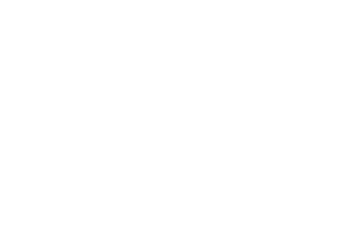

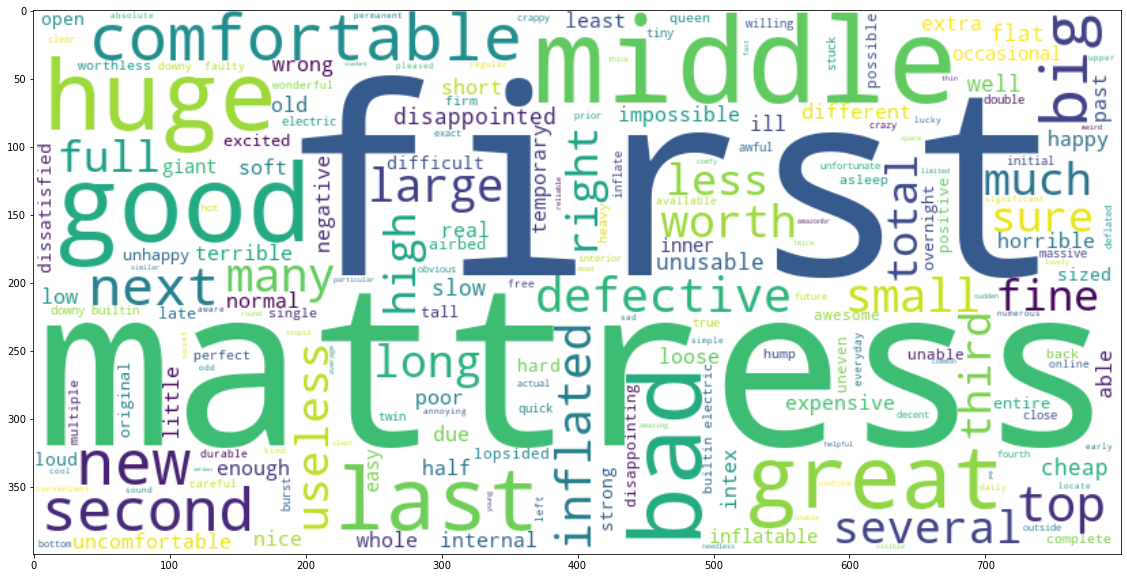

In [30]:
# 25 Create word cloud for 1 star reviews
# Text of all words in column customer reviews

text = " ".join(review for review in df_1star.reviews.astype(str))
print ("There are {} words in the combination of all cells in column reviews for 1-star.".format(len(text)))


# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(30,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


There are 76214 words in the combination of all cells in column reviews for 1-star.


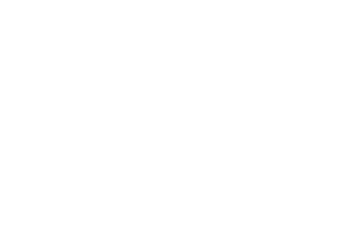

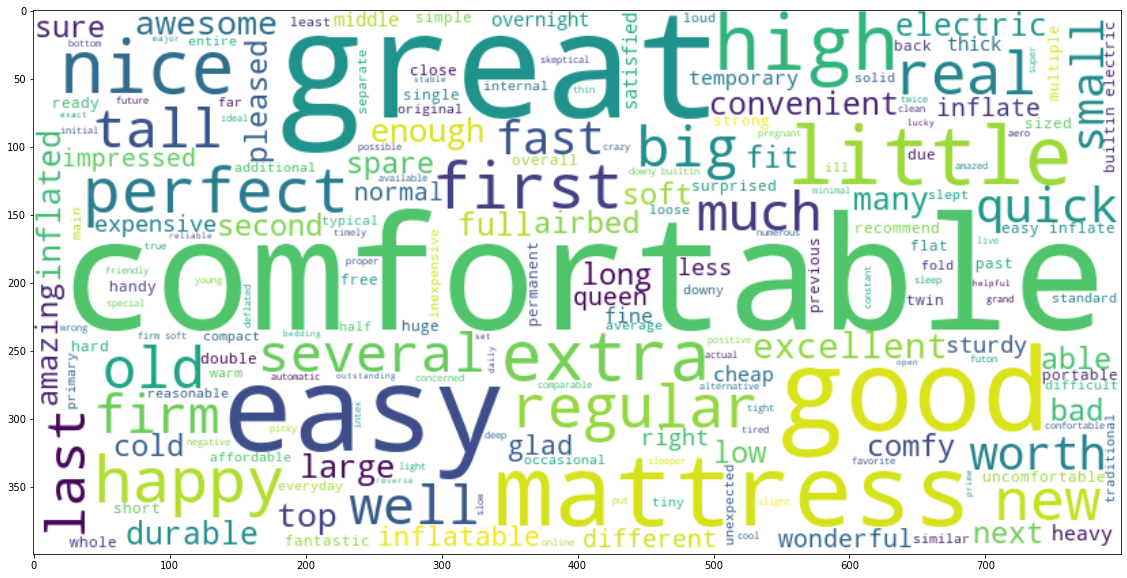

In [31]:
# 26 Create word cloud for 5 star reviews
# Text of all words in column customer reviews

text = " ".join(review for review in df_5stars.reviews.astype(str))
print ("There are {} words in the combination of all cells in column reviews for 1-star.".format(len(text)))


# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure( figsize=(30,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()